<a href="https://colab.research.google.com/github/yaobviously/PyMC3threes/blob/main/threes_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4
 
import pymc3 as pm
import arviz as az
import theano as tt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
threes_small_url = r'https://github.com/yaobviously/PyMC3threes/raw/main/threesmodel_small.csv'
threes_full_url = r'https://github.com/yaobviously/PyMC3threes/raw/main/threesfull.csv'

In [3]:
threes_data = pd.read_csv(threes_full_url)

# Player type labelling to add another level in future

players = threes_data['Player']
        
threes_att = np.array(threes_data['3PA']).T
threes_made = np.array(threes_data['3P']).T

sample_size = len(threes_att)


272


In [4]:
# Specifying the model

with pm.Model() as threes_model:

# This line specifies a uniform distribution over the prior probability of the
# sample's mean three point percentage

  phi = pm.Uniform('phi', lower = 0.0, upper = 1.0)
 
# These lines specify an exponential prior over kappa that is transformed
# into kappa.

  kappa_log = pm.Exponential("kappa_log", lam = 1.5)
  kappa = pm.Deterministic("kappa", np.exp(kappa_log))

# Each player gets their own 'theta', or estimated three point percentage. It is drawn
# from a combination specified by phi and kappa.

  thetas = pm.Beta("thetas", alpha = phi * kappa, beta = (1 - phi) * kappa, shape = sample_size)

# This specifies the proximate process generating the observations: the total number 
# of threes made. n = attempts, p = probability of a make.

  y = pm.Binomial("y", n = threes_att, p = thetas, observed = threes_made)


In [ ]:
# This line expresses the above model in plate notation, which allows us to examine
# the structure of the model.

pm.model_to_graphviz(threes_model)

In [ ]:
# Sampling the posterior given our data. It's in a separate cell in case we want
# to revise our model after examining it in plate notation.

with threes_model:
    trace = pm.sample(75000, tune=5000, chains=2)

In [84]:

summary = az.summary(trace)

In [ ]:

az.plot_trace(trace)

In [85]:
df2 = pd.DataFrame(trace.thetas)
df2.columns = players

means = df2.mean()
std = df2.std()

df3 = pd.concat([means, std], axis = 1)
df3.columns = ['est_3p%', 'std_est']


In [ ]:
threes_data['obs_3p%'] = (threes_data['3P'] / threes_data['3PA']).round(3)

comparison = pd.merge(threes_data, df3, how = 'left', left_index = True, right_on = 'Player')

comparison['delta'] = (comparison['est_3p%'] - comparison['obs_3p%']).round(3)

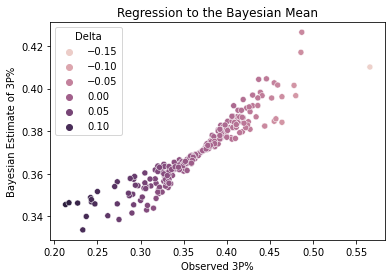

In [83]:

fig, ax = plt.subplots()


ax = sns.scatterplot(x = 'obs_3P%', y = 'est_3p%', hue = 'delta', data = comparison)
ax.set_xlabel('Observed 3P%')
ax.set_ylabel('Bayesian Estimate of 3P%')
ax.set_title('Regression to the Bayesian Mean')

plt.legend(title = 'Delta')
plt.savefig('bayesregression.png')
plt.show()

